# Introduction to Deep Learning Final project

### Description
#### Data description:
This is the final project for the course Introduction to Deep Learning. The dataset used in this project is <https://archive.ics.uci.edu/dataset/179/secom> secom dataset.

This dataset was generated in a complex modern semi-conductor manufacturing process which was under conssitent suiveillance via the monitoring of signals collected from sensors and or process measurement points. It contains a large number of entries with different signals as features collected from sensors. There are 1567 examples with 590 features.These data can be analyzed and transformed into knowledge to predict if a product produced is going to pass a in house line test. Among these samples, the labels represent a simple pass/fail yield for in house line testing that –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp  .

Data Citation:McCann,Michael and Johnston,Adrian. (2008). SECOM. UCI Machine Learning Repository. https://doi.org/10.24432/C54305.

#### Problem:
- There are too many features, and not all features are useful and relevant. It is often the case that useful information is buried in the noise and useless informaiton. This sensor data was generated under consistent suiveilance via the monitoring of signals/variables collected from sensors and or process measurement points, not all of these signals are equally valuable. A proper way to reduce the number of features and or extract most variance from the data is essential for the final model.
- Inbalanced data, failure (class 1) are much less common than padd (class -1).
- Data has time stapms, but how much the time stamps affects the inference.

#### Model of choose
- ML approach:
A combination of feature selection methods to reduce the dimension of the sensor data.Build one unsupervised clustering models and 4 supervised classifiers, using grideserach to tune hyperparameters of the models and compare between the models.
-  DL approach:
A DNN and a RNN will be build and compared with the ML model as well as each other.

In [434]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import seed

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Lasso

from imblearn.over_sampling import SMOTE
from collections import Counter 

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import tensorflow as tf
tf.random.set_seed(401)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import plot_model
%matplotlib inline
sns.set()

In [435]:
# seed
seed(420)
np.random.seed(420)
tf.random.set_seed(420)

In [436]:
# load the variable sensors' data 
path="secom.data"
sensors=pd.read_csv(path,header=None,sep=' ')
sensors.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [437]:
# take a look at the data
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB


 - sensors data has 1567 rows and 590 columns
 - sensors data only contains float data type

In [438]:
# rename columns
sensors.columns=['Sensor '+str(name) for name in sensors.columns]

In [439]:
# load the target senesor's data
path='secom_labels.data'
labels=pd.read_csv(path,header=None,sep=' ',names=['Label','Time'])
labels.head()

,Label,Time
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [440]:
# convert Time column to datetime formate
labels.Time=pd.to_datetime(labels.Time)

In [441]:
# take a look at the data
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Label   1567 non-null   int64         
 1   Time    1567 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.6 KB


 - the labels data has 1567 rows and 2 columns
 - the lables data contains the information of the class(label) and datetime

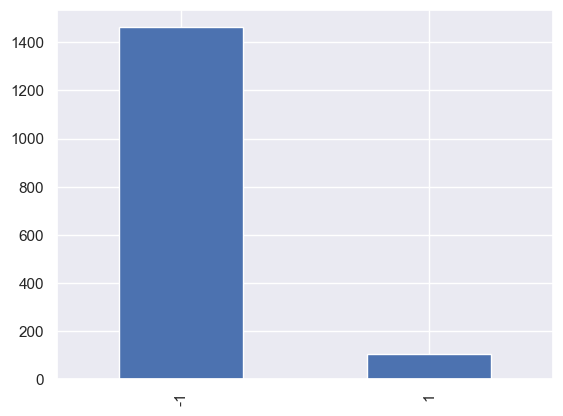

In [442]:
# chenck the class(Label) information
labels.Label.value_counts().plot(kind='bar');

 - class is imbalanced 

In [443]:
# encode classes (defalut product:1,good product:0)
labels.replace(to_replace=1,value=0,inplace=True)
labels.replace(to_replace=-1,value=1,inplace=True)

In [444]:
# merge data
data_original=pd.concat([sensors,labels],axis=1)
data_original.head()

,Sensor 0,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 582,Sensor 583,Sensor 584,Sensor 585,Sensor 586,Sensor 587,Sensor 588,Sensor 589,Label,Time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1,2008-07-19 15:22:00


In [445]:
#take a look at the data
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Sensor 0 to Time
dtypes: datetime64[ns](1), float64(590), int64(1)
memory usage: 7.1 MB


 - data has 1567 rows and 592 columns after merge
 - it contains 590 sensonrs' records, the final product's label and time stamps

In [446]:
# checking missing values
vars_with_na=[var for var in data_original.columns if data_original[var].isnull().sum()>0]
len(vars_with_na)

538

 -there are 538 columns contain missing values

In [447]:
# find out the percentage of observations missing per variable
data_na=data_original[vars_with_na].isnull().mean()
data_na=pd.DataFrame(data_na.reset_index())

# add column names to the result dataframe
data_na.columns=['variable','NA_%']
data_na.sort_values(by='NA_%',ascending=False,inplace=True)
data_na.head(10)

,variable,NA_%
269,Sensor 292,0.911934
270,Sensor 293,0.911934
145,Sensor 157,0.911934
146,Sensor 158,0.911934
335,Sensor 358,0.855775
84,Sensor 85,0.855775
458,Sensor 492,0.855775
208,Sensor 220,0.855775
481,Sensor 518,0.649649
231,Sensor 246,0.649649


In [448]:
data_na.tail(10)

,variable,NA_%
301,Sensor 324,0.000638
302,Sensor 325,0.000638
419,Sensor 453,0.000638
420,Sensor 454,0.000638
421,Sensor 455,0.000638
422,Sensor 456,0.000638
206,Sensor 218,0.000638
333,Sensor 356,0.000638
423,Sensor 457,0.000638
537,Sensor 589,0.000638


 - there are some columns contain high percentage of missing values.
 - we need to discard those columns as they are meaningless.

In [449]:
# capture variables with no or less than 5% NA

vars_ = [var for var in data_original.columns 
         if data_original[var].isnull().mean() < 0.05]
len(vars_)

540

In [450]:
# update the data
data=data_original[vars_].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 540 entries, Sensor 0 to Time
dtypes: datetime64[ns](1), float64(538), int64(1)
memory usage: 6.5 MB


In [451]:
# split the data without the time stemps
X_train,X_test,y_train,y_test=train_test_split(data.iloc[:,:-2],data.Label,
                                               test_size=0.2,random_state=420)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1253, 538), (314, 538), (1253,), (314,))

In [452]:
######## impute missing values by random sampling from training data

In [453]:
# numbers of NA in training and testing data set before NA imputation
X_train.isnull().sum().sum(),X_test.isnull().sum().sum()

(2896, 623)

In [454]:
def fill_na(df_train,df_test,var):
    # fucntion to fill NA in both training and testing set by random sampling
    # from training data
    
    # extract the number of missing values(sample numbers)
    n=df_train[var].isnull().sum()
    m=df_test[var].isnull().sum()
    
    # random sampling from training set
    
    random_state1=n # set the random_state unique to each sample
    random_sample_train=df_train[var].dropna().sample(n,random_state=n)
    
    random_state2=m
    random_sample_test=df_train[var].dropna().sample(m,random_state=m)
    

    # set the same index in order to merge datasets
    random_sample_train.index = df_train[df_train[var].isnull()].index
    random_sample_test.index = df_test[df_test[var].isnull()].index
    
    # replace NA
    df_train.loc[df_train[var].isnull(),var]=random_sample_train
    df_test.loc[df_test[var].isnull(),var]=random_sample_test


In [455]:
# fill NA in each column that contains missing values 
for i in list(vars_[:-2]):
    fill_na(X_train,X_test,i)
X_train.isnull().sum().sum(),X_test.isnull().sum().sum()

(0, 0)

###### feature selecting 

In [456]:
# remove constant features as they provide 
# no information to discriminate the target
constant_features=[feat for feat in X_train.columns if X_train[feat].std()==0]
X_train.drop(labels=constant_features,axis=1,inplace=True)
X_test.drop(labels=constant_features,axis=1,inplace=True)

X_train.shape,X_test.shape

((1253, 416), (314, 416))

In [457]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)

duplicated_feat=set(duplicated_feat)            
len(duplicated_feat)

0

 - there are no duplicated features

In [458]:
# remove features that contains most of the same values
low_var=[]
for var in X_train.columns:
    # get the features that more than 98% of values are the same
    if max(X_train[var].value_counts()/len(X_train))>0.98:
        low_var.append(var)
print(len(low_var))

4


In [459]:
# remove features
X_train.drop(labels=low_var,axis=1,inplace=True)
X_test.drop(labels=low_var,axis=1,inplace=True)

X_train.shape,X_test.shape

((1253, 412), (314, 412))

In [460]:
#  fucntion to remove correlated features
def correlation(dataset, threshold):
    # function to remove correlated features
    # remove features that have absolute correlation value that above threshold
    
    col_corr = set()  # Set of correlated features
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr


In [461]:
# numbers of correlated features
corr_features = correlation(X_train, 0.8)
print(f'correlated features: {len(set(corr_features))} ')

correlated features: 201 


In [462]:
# remove correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((1253, 211), (314, 211))

In [463]:
# remove features using LASSO
# scaler
scaler=StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [464]:
# LASSO
alpha=0.0225
# alpha = 0.045
clf=Lasso(alpha=alpha,random_state=401)
clf.fit(scaler.transform(X_train),y_train)
# print(clf.coef_)
_list=X_train.columns[clf.coef_!=0]
len(_list)

5

In [465]:
# columns that are selected
_list

Index(['Sensor 21', 'Sensor 59', 'Sensor 64', 'Sensor 103', 'Sensor 210'], dtype='object')

In [466]:
# update the features of the train-test set
X_train=X_train[_list]
X_test=X_test[_list]
X_train.shape, X_test.shape

((1253, 5), (314, 5))

In [467]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
Y_train_copy = y_train.copy()
Y_test_copy = y_test.copy()

In [468]:
X_train_copy.shape,X_test_copy.shape

((1253, 5), (314, 5))

In [469]:
y_train.shape,y_test.shape

((1253,), (314,))

### Further EDA 

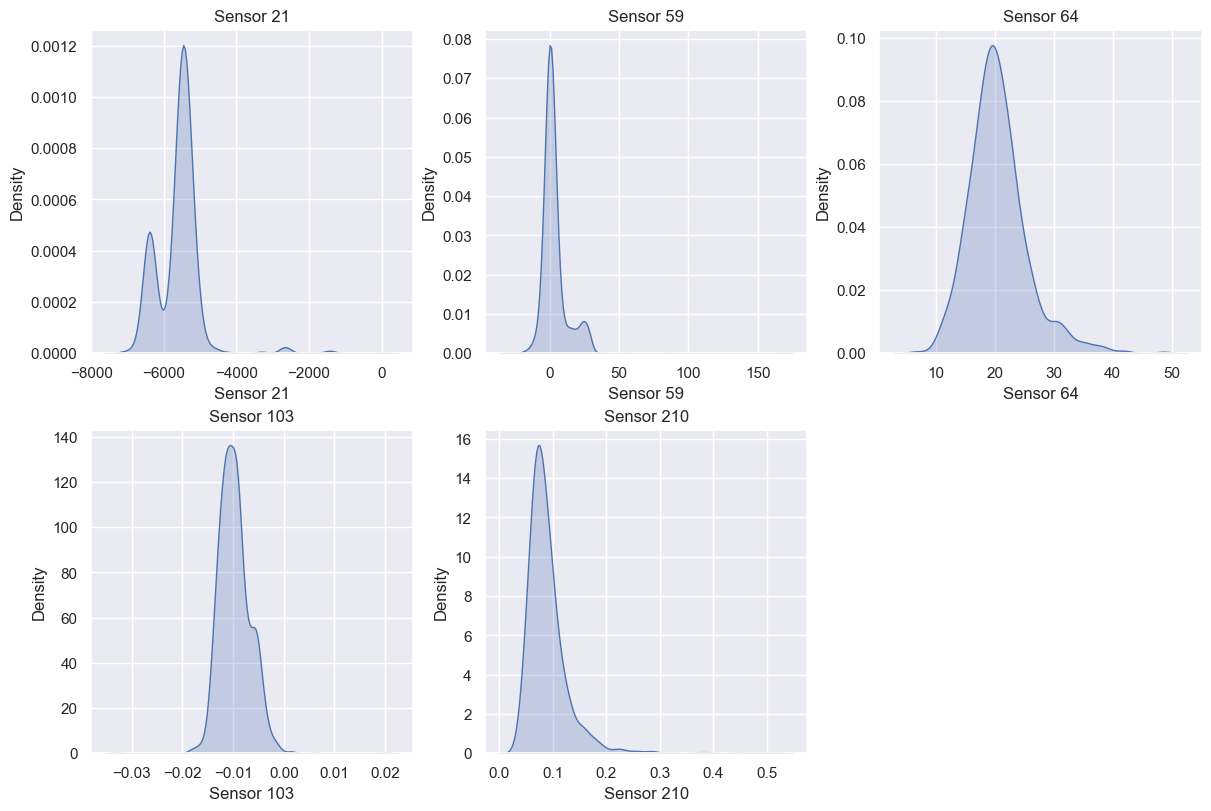

In [470]:
# visually explore the training dataset
def trim_axs(axs,N):
    # function to trim spare axs
    axs=axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

cases=X_train.columns
axs=plt.figure(figsize=(12,8),constrained_layout=True).subplots(2,3)
axs=trim_axs(axs,len(cases))
for ax,case in zip(axs,cases):
    ax.set_title(f'{case}',fontsize=12)
    sns.kdeplot(x=case,data=X_train,ax=ax,fill=True)

In [471]:
# function to create histogram, Q-Q plot and boxplot

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
    
    # for Q-Q plots
    import scipy.stats as stats
    
    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.kdeplot(x=variable,data=df,fill=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

plots of Sensor 21


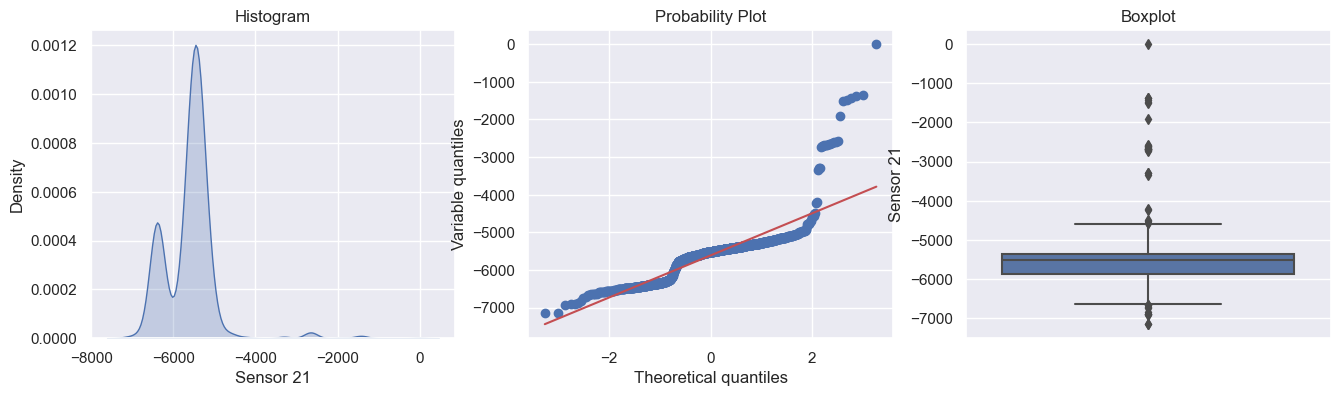

In [472]:
# find outliers in Sensor 21
print('plots of Sensor 21')
diagnostic_plots(X_train, 'Sensor 21')

- there are a lot of outliers in the right tail
- the distribution is not normal based on the Q-Q plot

plots of Sensor 59


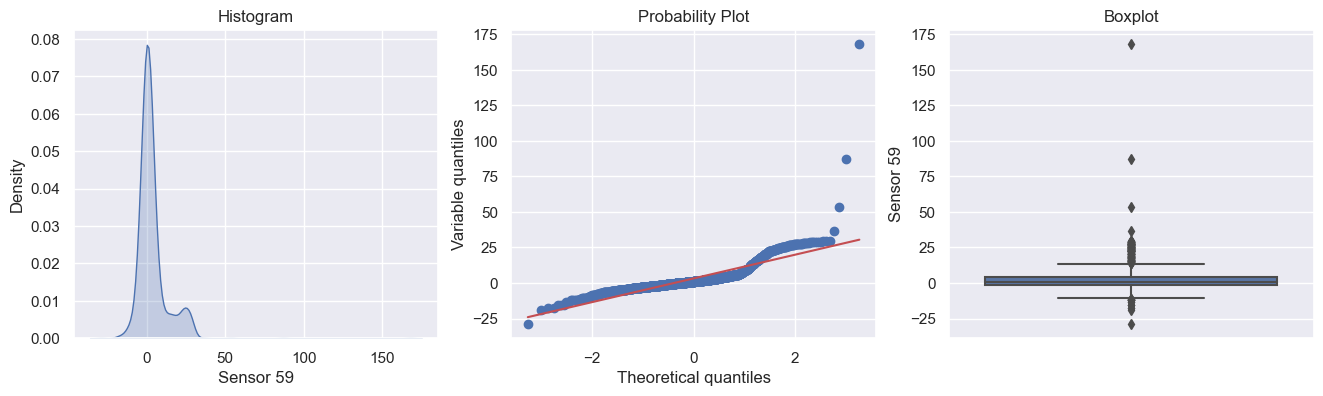

In [473]:
# find outliers in Sensor 59
print('plots of Sensor 59')
diagnostic_plots(X_train, 'Sensor 59')

- distribution plot and Q-Q plot show the dataset is normal-like shape with outliers most on the right tail.

plots of Sensor 64


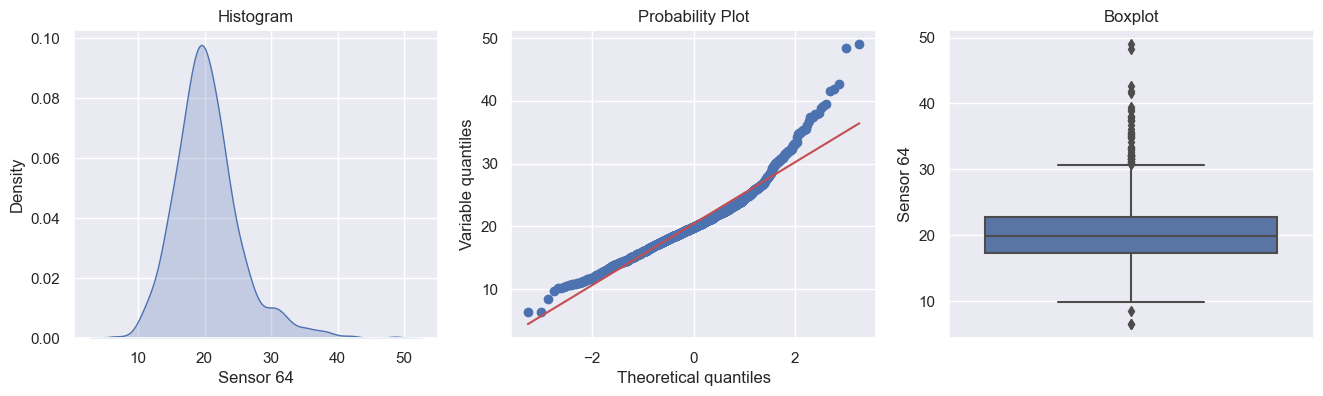

In [474]:
# find outliers in Sensor 64
print('plots of Sensor 64')
diagnostic_plots(X_train, 'Sensor 64')

- distribution is normal-like shape with outliers on both sides but mostly on the right tail.

plots of Sensor 103


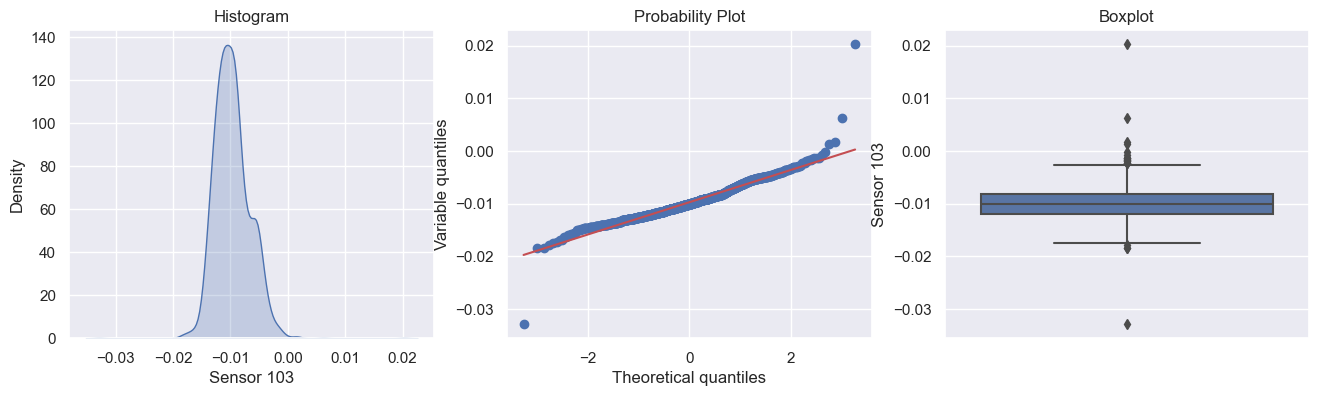

In [475]:
# find outliers in Sensor 103
print('plots of Sensor 103')
diagnostic_plots(X_train, 'Sensor 103')

- distribution is normal-like shape with outliers on both sides 

plots of Sensor 210


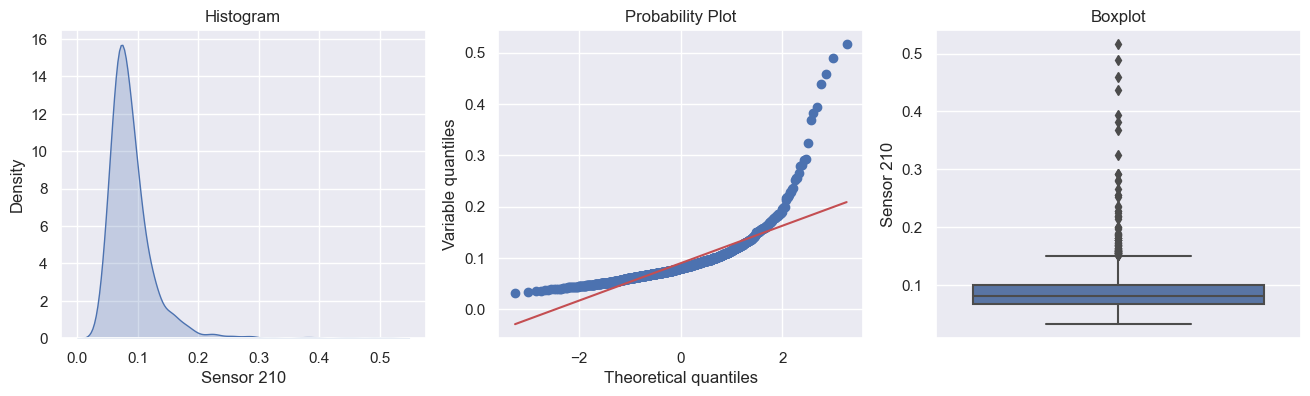

In [476]:
# find outliers in Sensor 210
print('plots of Sensor 210')
diagnostic_plots(X_train,'Sensor 210')

- distribution is normal-like shape with outliers on the right tail

In [477]:
# save a copy of cleaned datasets
data_cleaned=pd.DataFrame(pd.concat([X_train,X_test],axis=0))
label_cleaned=pd.DataFrame(pd.concat([y_train,y_test],axis=0))
data_cleaned.sort_index(inplace=True)
label_cleaned.sort_index(inplace=True)

In [478]:
data_2 = pd.concat([data_cleaned,label_cleaned,labels.Time],axis=1)
data_2.shape

(1567, 7)

##### resample classes 

In [479]:
# check the numbers of each class
y_train.value_counts()

1    1171
0      82
Name: Label, dtype: int64

In [480]:
# using SMOTE to balance the calsses
sm=SMOTE(random_state=401)
X_res,y_res=sm.fit_resample(X_train,y_train)

In [481]:
# update dataset
X_train_balanced=pd.DataFrame(X_res,columns=X_train.columns)
y_train_balanced=y_res

In [482]:
# number of examples after applying the algorithm
print(f"Original dataset length is {len(X_train)}")

#number of original dataset
print(f"Original dataset shape is:{sorted(Counter(y_train).items())}")

# number of examples after applying the algorithm
print(f"Resampled dataset length is {len(X_res)}")

# examples for each class
print(f"Resampled dataset shape is:{sorted(Counter(y_res).items())}")


Original dataset length is 1253
Original dataset shape is:[(0, 82), (1, 1171)]
Resampled dataset length is 2342
Resampled dataset shape is:[(0, 1171), (1, 1171)]


In [483]:
# update training and testing data
x_train=X_train_balanced
x_test=X_test
y_train=y_train_balanced
y_test=y_test

In [484]:
# scale 
scaler=MinMaxScaler()
scaler.fit(x_train)

MinMaxScaler()

In [485]:
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [486]:
# function to plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(6,3))
    plt.title('Cross Entropy Loss')
    plt.plot(history['loss'], color='blue', label='train')
    plt.plot(history['val_loss'], color='orange', label='val')
    plt.legend()

In [487]:
# funtion to evaluate model
def evalu_model(model,x_test,y_test):
    predictions=model.predict(x_test)
    print(classification_report(y_test,tf.round(predictions)))
    cm = confusion_matrix(y_test,tf.round(predictions))
    print(cm)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.yaxis.set_ticklabels(['Pass','Fail'])

### Model building


ML approach: random forest

In [488]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((2342, 5), (2342,), (314, 5), (314,))

In [489]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[100,300], 'criterion':['gini','entropy','log_loss'],
             'max_depth':[2,4,6]}
rf = RandomForestClassifier(random_state=401)
clf_rf= GridSearchCV(rf, parameters)
clf_rf.fit(x_train,y_train)

print(clf_rf.cv_results_.keys())
print(clf_rf.best_params_)
print(clf_rf.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 300}
0.8343238022342501


In [490]:
rf = RandomForestClassifier(random_state=420,criterion='gini',
                                             max_depth= 6, n_estimators= 300).fit(x_train,y_train)
# testing accuracy
y_hat_rf=rf.predict(x_test)
print(classification_report(y_test,y_hat_rf))

              precision    recall  f1-score   support

           0       0.19      0.41      0.26        22
           1       0.95      0.87      0.91       292

    accuracy                           0.83       314
   macro avg       0.57      0.64      0.58       314
weighted avg       0.90      0.83      0.86       314



In [491]:
# training accuracy
y_hat_train=rf.predict(x_train)
print(classification_report(y_train,y_hat_train))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1171
           1       0.88      0.88      0.88      1171

    accuracy                           0.88      2342
   macro avg       0.88      0.88      0.88      2342
weighted avg       0.88      0.88      0.88      2342



[Text(0, 0.5, 'Pass'), Text(0, 1.5, 'Fail')]

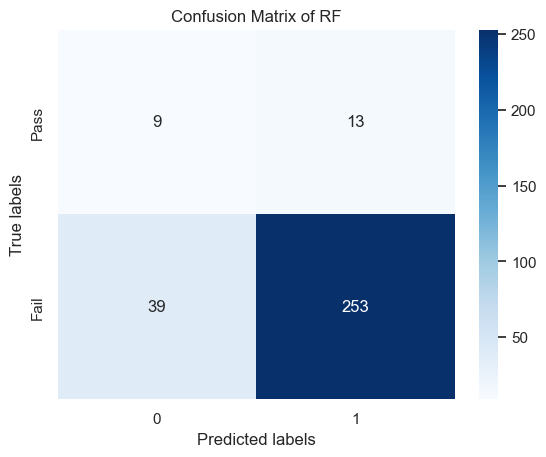

In [492]:
# plot the confusion matrix
cm = confusion_matrix(y_test,y_hat_rf)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap=plt.cm.Blues);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of RF')
ax.yaxis.set_ticklabels(['Pass','Fail'])

The model accuracy is 0.83, the misclassified number is 58. 

In [493]:
model_compare = pd.DataFrame([{'modle':'RF','acc':0.83,'num_miscls':52}])
model_compare

,modle,acc,num_miscls
0,RF,0.83,52


#### DNN

In [494]:
# split training data to traing and validation data (10%)
n_val=int(0.1*X_train.shape[0])
x_val_1,y_val_1=x_train[0:n_val].values,y_train[0:n_val].values
x_train_1,y_train_1=x_train[n_val:].values,y_train[n_val:].values
x_test=x_test.to_numpy()

In [495]:
# check the shape of all subdatasets
x_train_1.shape,y_train_1.shape,x_test.shape, y_test.shape,x_val_1.shape,y_val_1.shape

((2217, 5), (2217,), (314, 5), (314,), (125, 5), (125,))

In [496]:
# scale 
scaler=MinMaxScaler()
scaler.fit(x_train_1)
x_train_1scaled=scaler.transform(x_train_1)
x_test_1scaled=scaler.transform(x_test)
x_val_1scaled=scaler.transform(x_val_1)

In [497]:
# build a DNN model
model_DNN=keras.Sequential()

# hiden layers
model_DNN.add(Dense(5,activation='relu'))
model_DNN.add(Dropout(0.4))
model_DNN.add(Dense(20,activation='relu'))
model_DNN.add(Dropout(0.4))
model_DNN.add(Dense(20,activation='relu'))
model_DNN.add(Dropout(0.4))
model_DNN.add(Dense(10,activation='relu'))
model_DNN.add(Dropout(0.4))
model_DNN.add(Dense(5,activation='relu'))

# output layer 
model_DNN.add(Dense(1,activation='sigmoid'))

In [498]:
# compile model
model_DNN.compile(optimizer='adam',loss='binary_crossentropy')
# set early stop
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [499]:
# train model
model_DNN.fit(x_train_1scaled,y_train_1,epochs=150,
                 validation_data=(x_val_1scaled,y_val_1),verbose=1,callbacks=[early_stop])

Epoch 1/150
70/70 [==============================] - 3s 7ms/step - loss: 0.6929 - val_loss: 0.7151
Epoch 2/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6916 - val_loss: 0.7411
Epoch 3/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6888 - val_loss: 0.7638
Epoch 4/150
70/70 [==============================] - 0s 3ms/step - loss: 0.6905 - val_loss: 0.7430
Epoch 5/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6900 - val_loss: 0.7357
Epoch 6/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6878 - val_loss: 0.7352
Epoch 7/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6868 - val_loss: 0.7462
Epoch 8/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6866 - val_loss: 0.7370
Epoch 9/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6819 - val_loss: 0.7216
Epoch 10/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6798 - val_loss: 0.7326
Epoch 11/

70/70 [==============================] - 0s 4ms/step - loss: 0.6140 - val_loss: 0.5442
Epoch 84/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6116 - val_loss: 0.5236
Epoch 85/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6218 - val_loss: 0.5189
Epoch 86/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6115 - val_loss: 0.5280
Epoch 87/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6124 - val_loss: 0.5362
Epoch 88/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6101 - val_loss: 0.5372
Epoch 89/150
70/70 [==============================] - 0s 6ms/step - loss: 0.6160 - val_loss: 0.5309
Epoch 90/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6107 - val_loss: 0.5240
Epoch 91/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6150 - val_loss: 0.5234
Epoch 92/150
70/70 [==============================] - 0s 4ms/step - loss: 0.6091 - val_loss: 0.5162
Epoch 93/150


In [500]:
model_DNN.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 5)                 30        
                                                                 
 dropout_32 (Dropout)        (None, 5)                 0         
                                                                 
 dense_53 (Dense)            (None, 20)                120       
                                                                 
 dropout_33 (Dropout)        (None, 20)                0         
                                                                 
 dense_54 (Dense)            (None, 20)                420       
                                                                 
 dropout_34 (Dropout)        (None, 20)                0         
                                                                 
 dense_55 (Dense)            (None, 10)              

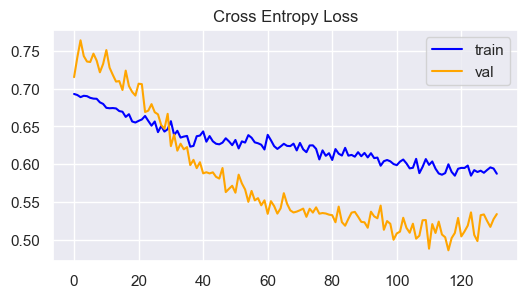

In [501]:
# plot the loss
history_DNN=pd.DataFrame(model_DNN.history.history)
summarize_diagnostics(history_DNN)

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.17      0.27      0.21        22
           1       0.94      0.90      0.92       292

    accuracy                           0.86       314
   macro avg       0.56      0.59      0.57       314
weighted avg       0.89      0.86      0.87       314

[[  6  16]
 [ 29 263]]


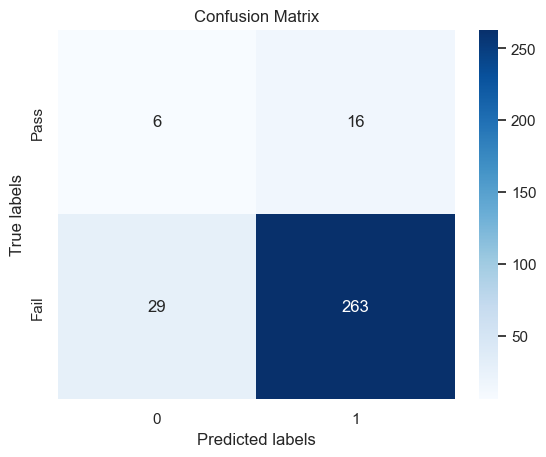

In [502]:
# evalueate model
evalu_model(model_DNN,x_test_1scaled,y_test)

- The DNN model has a accruacy of 0.86. 
- There are 45 misclassified products.

In [503]:
model_compare.loc[1] = ['DNN',0.86,45]
model_compare

,modle,acc,num_miscls
0,RF,0.83,52
1,DNN,0.86,45


####  RNN 

In [504]:
# get the clearned data with time stamps
data_rnn=pd.DataFrame(pd.concat([data_cleaned,label_cleaned,labels.Time],axis=1))
data_rnn=data_rnn.set_index('Time')
# # sort dataframe in time line
data_rnn.sort_index(inplace=True)

In [505]:
data_rnn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1567 entries, 2008-01-08 02:02:00 to 2008-12-10 18:47:00
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sensor 21   1567 non-null   float64
 1   Sensor 59   1567 non-null   float64
 2   Sensor 64   1567 non-null   float64
 3   Sensor 103  1567 non-null   float64
 4   Sensor 210  1567 non-null   float64
 5   Label       1567 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 85.7 KB


In [506]:
# take a look at the sorted dataframe
data_rnn.head

<bound method NDFrame.head of                      Sensor 21  Sensor 59  Sensor 64  Sensor 103  Sensor 210  \
Time                                                                           
2008-01-08 02:02:00   -5667.50    16.4582    23.5418     -0.0057      0.1703   
2008-01-08 05:52:00   -5501.75     9.0500    30.9500     -0.0057      0.0672   
2008-01-08 10:20:00   -5382.50    18.8309    21.1691     -0.0064      0.0644   
2008-01-08 10:26:00   -5659.25    18.2809    21.7191     -0.0053      0.0476   
2008-01-08 11:28:00   -5349.00    19.8000    20.2000     -0.0074      0.0520   
...                        ...        ...        ...         ...         ...   
2008-12-10 02:59:00   -6473.25     1.2518    18.7482     -0.0112      0.1404   
2008-12-10 03:21:00   -5459.50     0.0064    19.9936     -0.0126      0.0906   
2008-12-10 03:28:00   -5351.75     2.1927    17.8073     -0.0130      0.0833   
2008-12-10 08:19:00   -6514.50     3.6664    16.3336     -0.0126      0.0667   
2008-12-10

In [507]:
data_rnn.index.max(),data_rnn.index.min()

(Timestamp('2008-12-10 18:47:00'), Timestamp('2008-01-08 02:02:00'))

- The time stamp was across the whole year of 2008, from Jan to Dec

In [508]:
# frequency table 
month,counts,badproduct=[],[],[]
for i in range(1,13):
    count=len(data_rnn.loc['2008-'+str(i)])
    counts.append(count)
    s = np.sum(data_rnn.loc['2008-'+str(i)]['Label'])
    month.append(i)
    badproduct.append(count-s)

Fre=pd.DataFrame()
Fre['Month']=month
Fre['Counts']=counts
Fre['BadP']=badproduct
Fre['P%'] = Fre['BadP']/Fre['Counts']
Fre

,Month,Counts,BadP,P%
0,1,51,3,0.058824
1,2,98,5,0.051020
2,3,50,1,0.020000
3,4,49,3,0.061224
4,5,62,7,0.112903
5,6,67,6,0.089552
6,7,114,16,0.140351
7,8,471,38,0.080679
8,9,413,17,0.041162
9,10,123,6,0.048780


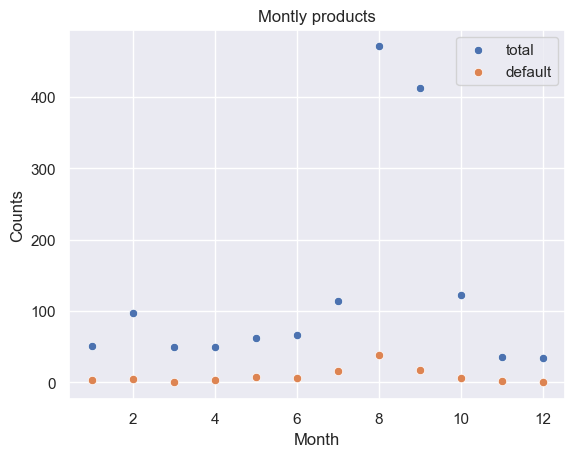

In [509]:
sns.scatterplot(Fre,x='Month',y = 'Counts',label='total')
sns.scatterplot(Fre,x ='Month',y='BadP',label='default')
plt.title('Montly products');

- We can see that August and September has way bigger number of total products than other monthes. Nov and Dec has the smallest number of products.
- As for the number of default product, August has the highest number of default which make sense as the total number of product of August is bigger than other months. 
- From the product table we can see that the default products number does not have a univerasl percentage to its total products number for each month.
- August does not have the highest percentage of default products, May and July have higher percentage of default products.
- There is no default product in Dec.

In [510]:
# scale data
scaler=MinMaxScaler()
data_rnn_scaled=scaler.fit_transform(data_rnn[data_rnn.columns].to_numpy())
data_rnn_scaled=pd.DataFrame(data_rnn_scaled,columns=data_rnn.columns,index=data_rnn.index)
data_rnn_scaled

,Sensor 21,Sensor 59,Sensor 64,Sensor 103,Sensor 210,Label
Time,,,,,,
2008-01-08 02:02:00,0.207370,0.230536,0.401824,0.511278,0.285655,1.0
2008-01-08 05:52:00,0.230551,0.192956,0.575971,0.511278,0.072859,0.0
2008-01-08 10:20:00,0.247229,0.242572,0.346048,0.498120,0.067079,1.0
2008-01-08 10:26:00,0.208524,0.239782,0.358977,0.518797,0.032405,1.0
2008-01-08 11:28:00,0.251914,0.247488,0.323268,0.479323,0.041486,1.0
...,...,...,...,...,...,...
2008-12-10 02:59:00,0.094682,0.153398,0.289140,0.407895,0.223942,1.0
2008-12-10 03:21:00,0.236460,0.147081,0.318416,0.381579,0.121156,1.0
2008-12-10 03:28:00,0.251530,0.158171,0.267022,0.374060,0.106089,1.0


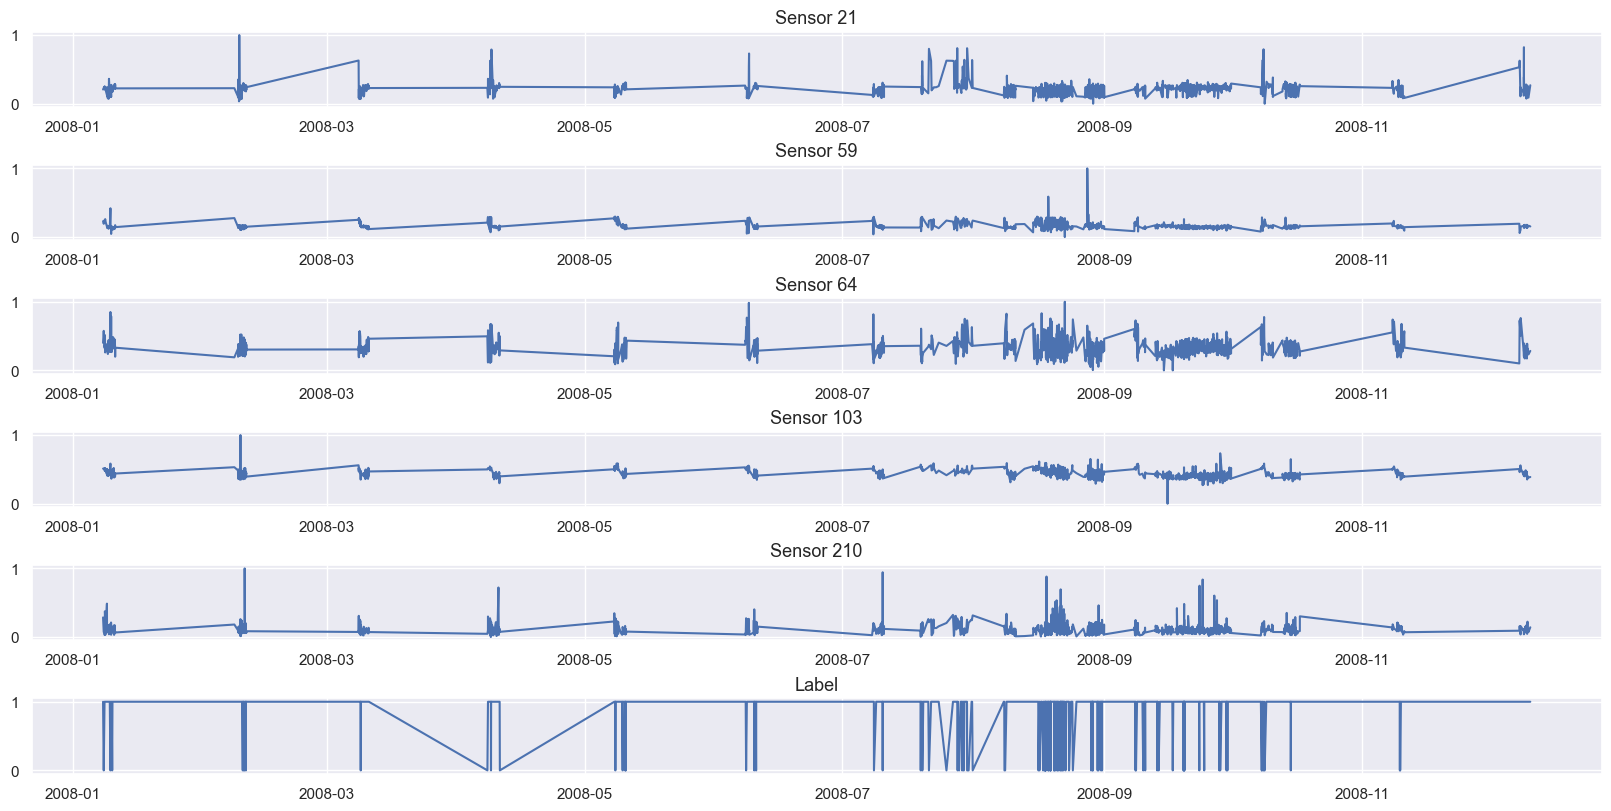

In [511]:
# plot all the columns agaist the time stamps through the year
ax=plt.figure(figsize=(16,8),constrained_layout=True).subplots(6,1)
ax[0].plot(data_rnn_scaled['Sensor 21'])
ax[0].set_title('Sensor 21',fontsize=13)
ax[1].plot(data_rnn_scaled['Sensor 59'])
ax[1].set_title('Sensor 59',fontsize=13)
ax[2].plot(data_rnn_scaled['Sensor 64'])
ax[2].set_title('Sensor 64',fontsize=13)
ax[3].plot(data_rnn_scaled['Sensor 103'])
ax[3].set_title('Sensor 103',fontsize=13)
ax[4].plot(data_rnn_scaled['Sensor 210'])
ax[4].set_title('Sensor 210',fontsize=13)
ax[5].plot(data_rnn_scaled['Label'])
ax[5].set_title('Label',fontsize=13);

- there are some seasonalities from the plots, but could just be the fact that there are only 3 days(8,9,10) have data entry in each month, also some month have more data than others.(month 7,8,9,10 have more data entries)

In [512]:
# divide dataset to 12 subsets, one for each month
subsets=['sub_'+str(i) for i in range(1,13)]
j=0
for i in range(12):
    k=Fre['Counts'][i]
    subsets[i]=data_rnn_scaled[j:k+j]
    j+=k

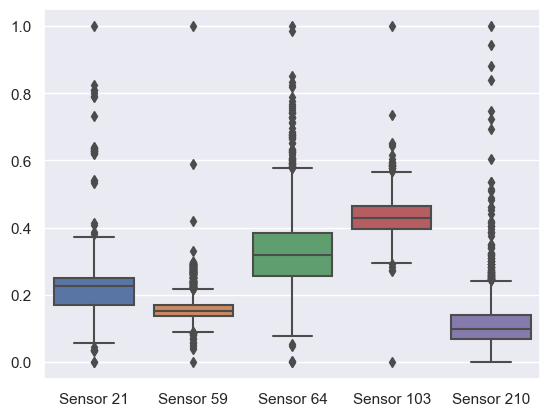

In [513]:
sns.boxplot(data_rnn_scaled.iloc[:,:-1]);

- Most of Sensor 21 readings are in range of 0.1 to 0.3
- Most of Sensor 59 readings are in range of 0.1 to 0.3
- Most of Sensor 64 readings are in range of 0.3 to 0.4 and has a long tail on the higher end.
- Most of Sensor 103 readings are in range of 0.4 to 0.5
- Most of Sensor 210 readings are in range of 0.05 to 0.15 and has a long tail on the higher end

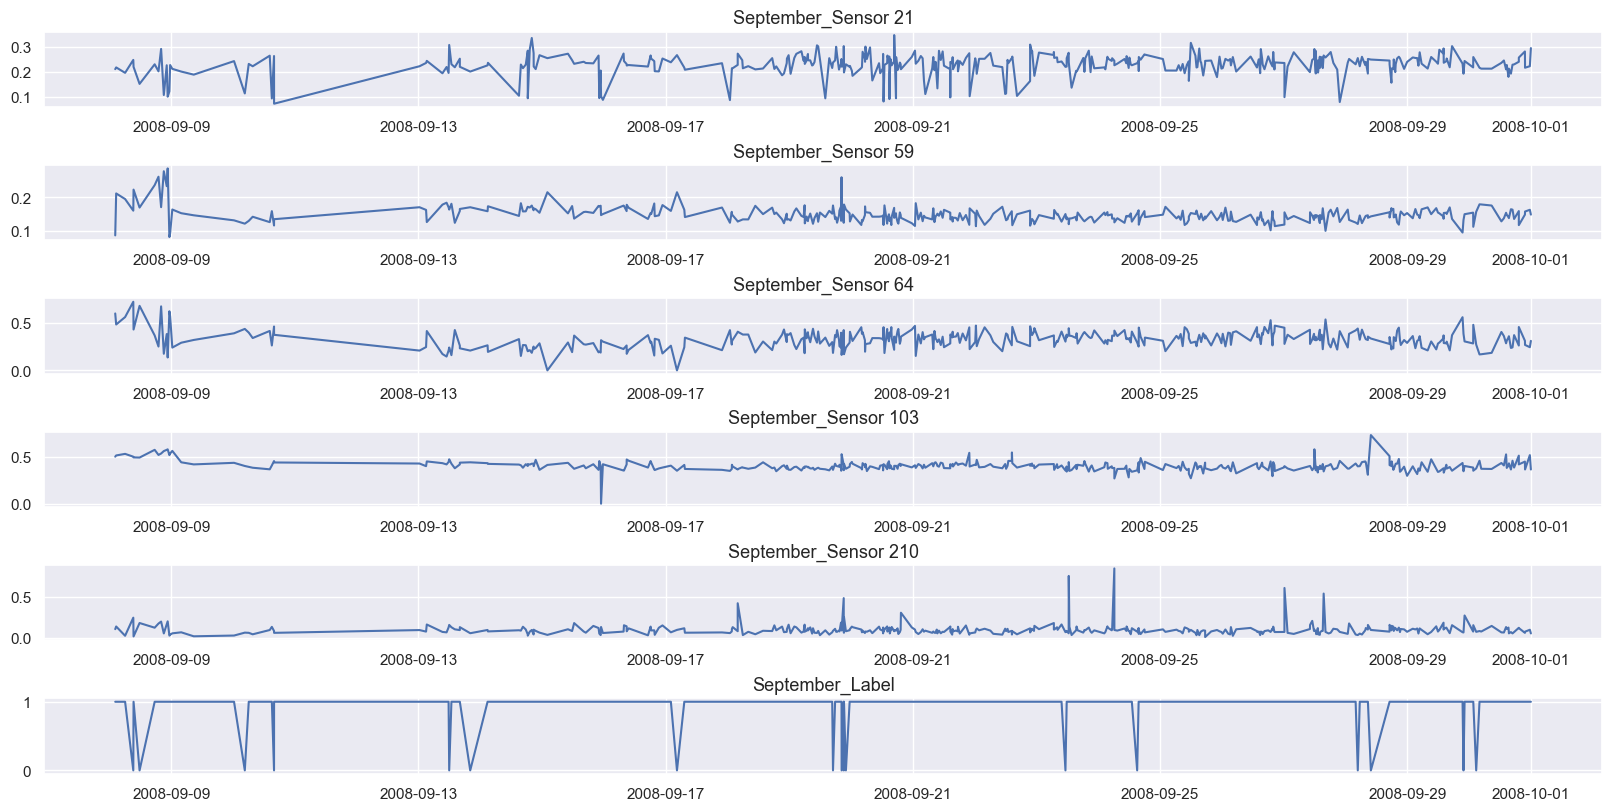

In [514]:
# plot all the columns agaist the time stamps for a month [ september]
ax=plt.figure(figsize=(16,8),constrained_layout=True).subplots(6,1)
ax[0].plot(subsets[8]['Sensor 21'])
ax[0].set_title('September_Sensor 21',fontsize=13)
ax[1].plot(subsets[8]['Sensor 59'])
ax[1].set_title('September_Sensor 59',fontsize=13)
ax[2].plot(subsets[8]['Sensor 64'])
ax[2].set_title('September_Sensor 64',fontsize=13)
ax[3].plot(subsets[8]['Sensor 103'])
ax[3].set_title('September_Sensor 103',fontsize=13)
ax[4].plot(subsets[8]['Sensor 210'])
ax[4].set_title('September_Sensor 210',fontsize=13)
ax[5].plot(subsets[8]['Label'])
ax[5].set_title('September_Label',fontsize=13);

- we can see that whenever there is a default product (class 0), the sensor readings fluctuates. For example, between 2008-09-17 and 2008-09-21, there was a batch of defaut products, the sensor 210,103,59,21 had a peak here that is out of its usual range, and sensor 64 fluctuated a lot. 

In [515]:
def train_test_split(data,rate_val,rate_test):
    # function to split the TS data into train
    # and validation ,test datasets 
    # rate_val is the validation size percentage to training data
    # rate_test is the test size percentage(0-1)
    test_n=int(len(data)*rate_test)
    train=data.iloc[:-test_n]
    test=data.iloc[-test_n:]
    val_n=int(len(train)*rate_val)
    x_train=train.drop('Label',axis=1).iloc[:-val_n]
    y_train=train.Label.iloc[:-val_n]
    x_test=test.drop('Label',axis=1)
    y_test=test.Label
    x_val=train.drop('Label',axis=1).iloc[-val_n:]
    y_val=train.Label.iloc[-val_n:]
    return x_train,y_train,x_test,y_test,x_val,y_val

In [516]:
length=4 # using how many samples to predict the next one
batch_size=1
rate_val=.2
rate_test=.2

In [517]:
# define RNN model
model_rnn=Sequential()

model_rnn.add(LSTM(100,input_shape=(length,x_train.shape[1])))

model_rnn.add(Dense(x_train.shape[1],activation='relu'))
model_rnn.add(Dropout(.4))
model_rnn.add(Dense(5,activation='relu'))
##########
model_rnn.add(Dense(x_train.shape[1],activation='relu'))
model_rnn.add(Dropout(.4))
#########
model_rnn.add(Dense(1,activation='sigmoid'))

In [518]:
# compile model
model_rnn.compile(optimizer='adam',loss='binary_crossentropy')

In [519]:
model_rnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               42400     
                                                                 
 dense_58 (Dense)            (None, 5)                 505       
                                                                 
 dropout_36 (Dropout)        (None, 5)                 0         
                                                                 
 dense_59 (Dense)            (None, 5)                 30        
                                                                 
 dense_60 (Dense)            (None, 5)                 30        
                                                                 
 dropout_37 (Dropout)        (None, 5)                 0         
                                                                 
 dense_61 (Dense)            (None, 1)               

In [520]:
# set early stop
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [521]:
# function to evaluate the RNN model
def evalu_model_rnn(model,x_test,y_test,length):
    test_predictions=[]
    class_predictions=[]
    first_batch=x_test[-length:]
    current_batch=first_batch.values.reshape(1,length,x_test.shape[1])
    
    for i in range(len(x_test)):
        # function to extract the output of the last hiden layer(predicted sensor readings)
        extractor = keras.Model(inputs=model.inputs,
                                outputs=[layer.output for layer in model.layers])
        # predictions of all the sensors from the last hiden layer(not the class from output layer)
        layer_outputs=extractor(current_batch)
        current_pred = layer_outputs[-2][0]
        # predicted class
        current_pred_class=model.predict(current_batch)[0][0]
        test_predictions.append(current_pred)
        class_predictions.append(current_pred_class)
        # update the next batch(drop the first sample and add the previous sensors prediction)
        current_pred=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    return class_predictions

Month1
Epoch 1/100
29/29 [==============================] - 5s 34ms/step - loss: 0.6864 - val_loss: 0.6817
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6590 - val_loss: 0.6701
Epoch 3/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6313 - val_loss: 0.6574
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6106 - val_loss: 0.6435
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5863 - val_loss: 0.6264
Epoch 6/100
29/29 [==============================] - 0s 8ms/step - loss: 0.5539 - val_loss: 0.6123
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5372 - val_loss: 0.6016
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 0.4667 - val_loss: 0.5896
Epoch 9/100
29/29 [==============================] - 0s 8ms/step - loss: 0.4272 - val_loss: 0.5788
Epoch 10/100
29/29 [==============================] - 0s 8ms/step - loss: 0.4368 - val_loss: 0.5716
E

Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 0.2951 - val_loss: 0.0273
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 0.1810 - val_loss: 0.0275
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.2531 - val_loss: 0.0286
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 0.1358 - val_loss: 0.0278
Epoch 6/100
28/28 [==============================] - 0s 14ms/step - loss: 0.1199 - val_loss: 0.0268
Epoch 7/100
28/28 [==============================] - 0s 8ms/step - loss: 0.2693 - val_loss: 0.0276
Epoch 8/100
28/28 [==============================] - 0s 10ms/step - loss: 0.2768 - val_loss: 0.0277
Epoch 9/100
28/28 [==============================] - 0s 8ms/step - loss: 0.2578 - val_loss: 0.0298
Epoch 10/100
28/28 [==============================] - 0s 11ms/step - loss: 0.1828 - val_loss: 0.0297
Epoch 11/100
28/28 [==============================] - 0s 8ms/step - loss: 0.1880 - val_loss: 0.0300
Epoch

1/1 [==============================] - 0s 39ms/step
Month7
Epoch 1/100
70/70 [==============================] - 1s 7ms/step - loss: 0.3096 - val_loss: 0.4494
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.2598 - val_loss: 0.4482
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.3350 - val_loss: 0.4454
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.3322 - val_loss: 0.4410
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.3102 - val_loss: 0.4389
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.3250 - val_loss: 0.4354
Epoch 7/100
70/70 [==============================] - 0s 6ms/step - loss: 0.3222 - val_loss: 0.4340
Epoch 8/100
70/70 [==============================] - 0s 7ms/step - loss: 0.3171 - val_loss: 0.4320
Epoch 9/100
70/70 [==============================] - 0s 6ms/step - loss: 0.3048 - val_loss: 0.4316
Epoch 10/100
70/70 [==============================

298/298 [==============================] - 2s 6ms/step - loss: 0.3261 - val_loss: 0.2042
Epoch 23/100
298/298 [==============================] - 2s 6ms/step - loss: 0.3235 - val_loss: 0.2028
Epoch 24/100
298/298 [==============================] - 2s 6ms/step - loss: 0.3234 - val_loss: 0.2016
Epoch 25/100
298/298 [==============================] - 2s 6ms/step - loss: 0.3301 - val_loss: 0.2059
Epoch 26/100
298/298 [==============================] - 2s 6ms/step - loss: 0.3206 - val_loss: 0.2020
Epoch 27/100
298/298 [==============================] - 2s 6ms/step - loss: 0.3236 - val_loss: 0.2020
Epoch 27: early stopping
1/1 [==============================] - 0s 35ms/step
Month9
Epoch 1/100
261/261 [==============================] - 2s 7ms/step - loss: 0.2002 - val_loss: 0.0952
Epoch 2/100
261/261 [==============================] - 2s 7ms/step - loss: 0.1862 - val_loss: 0.0778
Epoch 3/100
261/261 [==============================] - 2s 6ms/step - loss: 0.2014 - val_loss: 0.0752
Epoch 4/100
26

261/261 [==============================] - 2s 6ms/step - loss: 0.1761 - val_loss: 0.0502
Epoch 28/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1772 - val_loss: 0.0497
Epoch 29/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1778 - val_loss: 0.0493
Epoch 30/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1745 - val_loss: 0.0475
Epoch 31/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1787 - val_loss: 0.0463
Epoch 32/100
261/261 [==============================] - 2s 7ms/step - loss: 0.1768 - val_loss: 0.0456
Epoch 33/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1782 - val_loss: 0.0457
Epoch 34/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1809 - val_loss: 0.0467
Epoch 35/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1763 - val_loss: 0.0468
Epoch 36/100
261/261 [==============================] - 2s 6ms/step - loss: 0.1743 - val_loss: 

1/1 [==============================] - 0s 34ms/step
Month11
Epoch 1/100
19/19 [==============================] - 0s 11ms/step - loss: 0.2145 - val_loss: 0.0653
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2140 - val_loss: 0.0646
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2198 - val_loss: 0.0640
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1962 - val_loss: 0.0642
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2176 - val_loss: 0.0644
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2149 - val_loss: 0.0643
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2008 - val_loss: 0.0640
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2160 - val_loss: 0.0639
Epoch 9/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2170 - val_loss: 0.0647
Epoch 10/100
19/19 [============================

19/19 [==============================] - 0s 9ms/step - loss: 0.0434 - val_loss: 0.0350
Epoch 31/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0324 - val_loss: 0.0342
Epoch 32/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0404 - val_loss: 0.0336
Epoch 33/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0357 - val_loss: 0.0329
Epoch 34/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0365 - val_loss: 0.0322
Epoch 35/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0351 - val_loss: 0.0316
Epoch 36/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0330 - val_loss: 0.0309
Epoch 37/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0359 - val_loss: 0.0303
Epoch 38/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0336 - val_loss: 0.0296
Epoch 39/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0289
Epoch 40/100

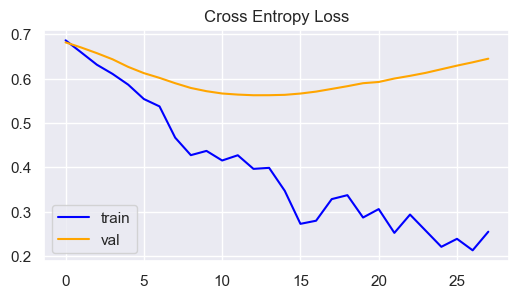

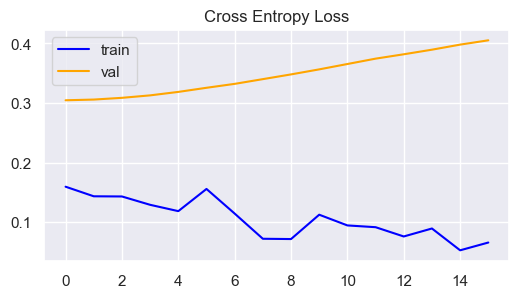

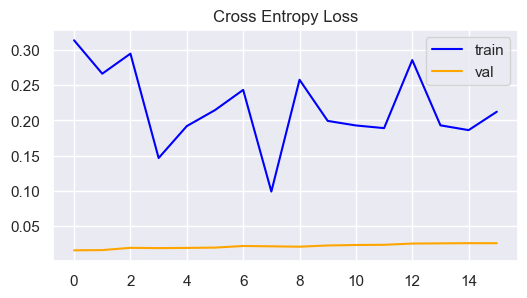

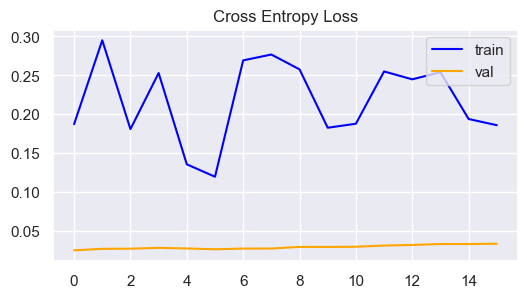

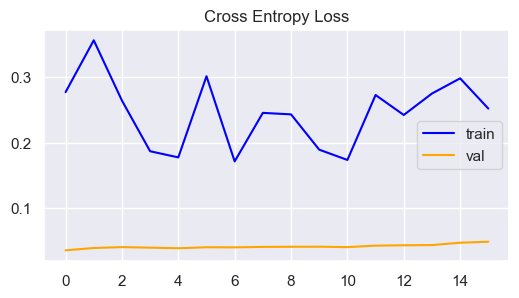

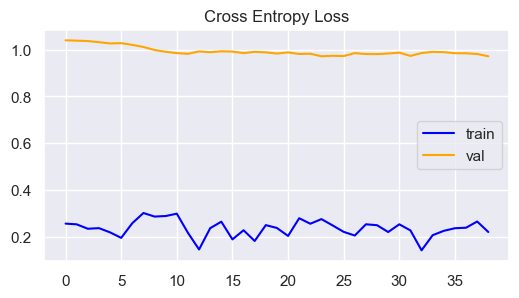

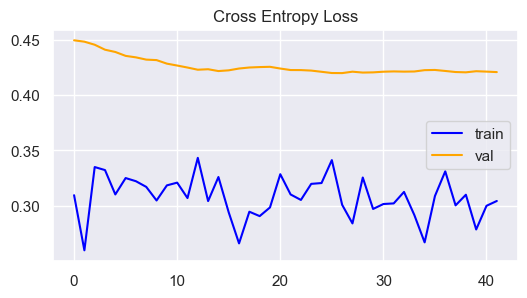

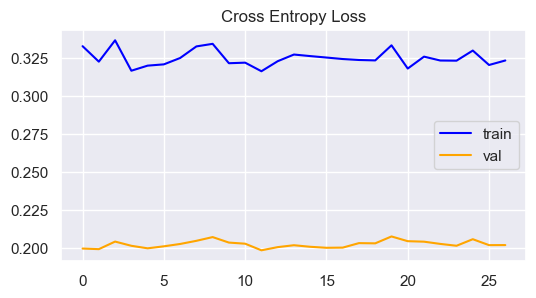

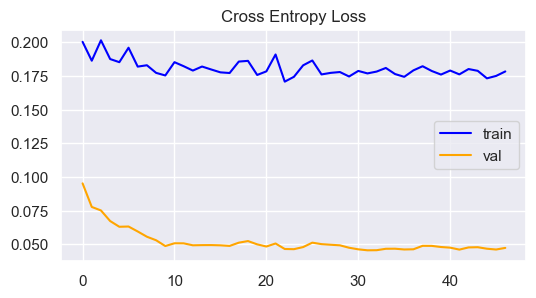

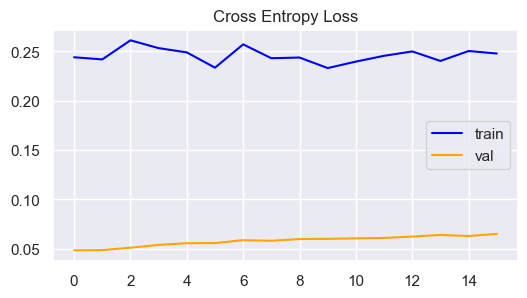

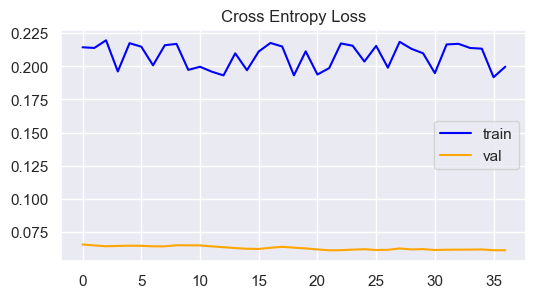

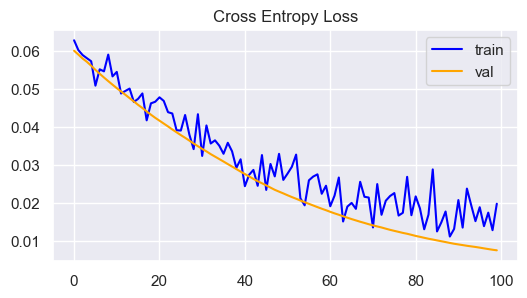

In [522]:
# train and validate all the subsets(each month)
length=4 # using how many samples to predict the next one
batch_size=1
rate_val=.2
rate_test=.2
acc_scores=[]
CM = []
for i in range(12):
    
    # split data of each month into training/validation/test datasets
    subset=subsets[i]
    x_train,y_train,x_test,y_test,x_val,y_val=train_test_split(subset,.2,.2)
    
    # generate the TS data into desired length and batch
    generator=TimeseriesGenerator(x_train,y_train,length=length,batch_size=batch_size)
    val_generator=TimeseriesGenerator(x_val,y_val,length=length,batch_size=batch_size)
    
    # train RNN model
    print('Month'+str(i+1))
    model_rnn.fit(generator,epochs=100,validation_data=val_generator,callbacks=[early_stop])
    
    # plot the loss
    history_rnn=pd.DataFrame(model_rnn.history.history)
    summarize_diagnostics(history_rnn)
    
    # prediction
    predictions=evalu_model_rnn(model_rnn,x_test,y_test,length)
    # accuracy scores of each month
    acc_score=accuracy_score(y_test,tf.round(predictions)).round(2)
    acc_scores.append(acc_score)
    cm = confusion_matrix(y_test,tf.round(predictions))
    CM.append(cm)

In [523]:
# update the Fre dataframe , add model accuracy of each month
Fre['accuracy']=acc_scores

In [524]:
# model accuracy
print(f'RNN model accuracy is {np.mean(acc_scores).round(2)}')

RNN model accuracy is 0.91


- model accuracy is the average of 12 month 's accuracy and it is good 

In [525]:
model_compare.loc[2] = ['RNN',0.91,24]
model_compare

,modle,acc,num_miscls
0,RF,0.83,52
1,DNN,0.86,45
2,RNN,0.91,24


In [526]:
# take a look at each month
Fre

,Month,Counts,BadP,P%,accuracy
0,1,51,3,0.058824,1.00
1,2,98,5,0.051020,0.84
2,3,50,1,0.020000,1.00
3,4,49,3,0.061224,0.89
4,5,62,7,0.112903,0.58
5,6,67,6,0.089552,1.00
6,7,114,16,0.140351,0.68
7,8,471,38,0.080679,0.96
8,9,413,17,0.041162,0.95
9,10,123,6,0.048780,1.00


- the prediction of most monthes are good but May and July are bad

- plot May and July es(bad month)to compair with a good month Sep(not may entries as may)

In [527]:
def plot_month(i):
    # i is the month index
    # plot all the columns agaist the time stamps for a month [ August]
    fig,ax=plt.subplots(6,1,figsize=(16,8),constrained_layout=True)
    sns.scatterplot(y=subsets[i]['Sensor 21'],x=subsets[i].index,hue=subsets[i]['Label'],ax=ax[0],alpha=0.5,legend=False)
    ax[0].set_title('Sensor 21',fontsize=13)
    ax[0].set(xlabel=None)
    ax[0].set(ylabel=None)
    sns.scatterplot(y=subsets[i]['Sensor 59'],x=subsets[i].index,hue=subsets[i]['Label'],ax=ax[1],alpha=0.5,legend=False)
    ax[1].set_title('Sensor 59',fontsize=13)
    ax[1].set(xlabel=None)
    ax[1].set(ylabel=None)
    sns.scatterplot(y=subsets[i]['Sensor 64'],x=subsets[i].index,hue=subsets[i]['Label'],ax=ax[2],alpha=0.5,legend=False)
    ax[2].set_title('Sensor 64',fontsize=13)
    ax[2].set(xlabel=None)
    ax[2].set(ylabel=None)
    sns.scatterplot(y=subsets[i]['Sensor 103'],x=subsets[i].index,hue=subsets[i]['Label'],ax=ax[3],alpha=0.5,legend=False)
    ax[3].set_title('Sensor 103',fontsize=13)
    ax[3].set(xlabel=None)
    ax[3].set(ylabel=None)
    sns.scatterplot(y=subsets[i]['Sensor 210'],x=subsets[i].index,hue=subsets[i]['Label'],ax=ax[4],alpha=0.5,legend=False)
    ax[4].set_title('Sensor 210',fontsize=13)
    ax[4].set(xlabel=None)
    ax[4].set(ylabel=None)
    sns.scatterplot(y=subsets[i]['Label'],x=subsets[i].index,hue=subsets[i]['Label'],ax=ax[5],alpha=0.5)
    ax[5].set_title('Label',fontsize=13)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    fig.suptitle(f'Month {i+1}: sensor readings and labels', fontsize=15)
    

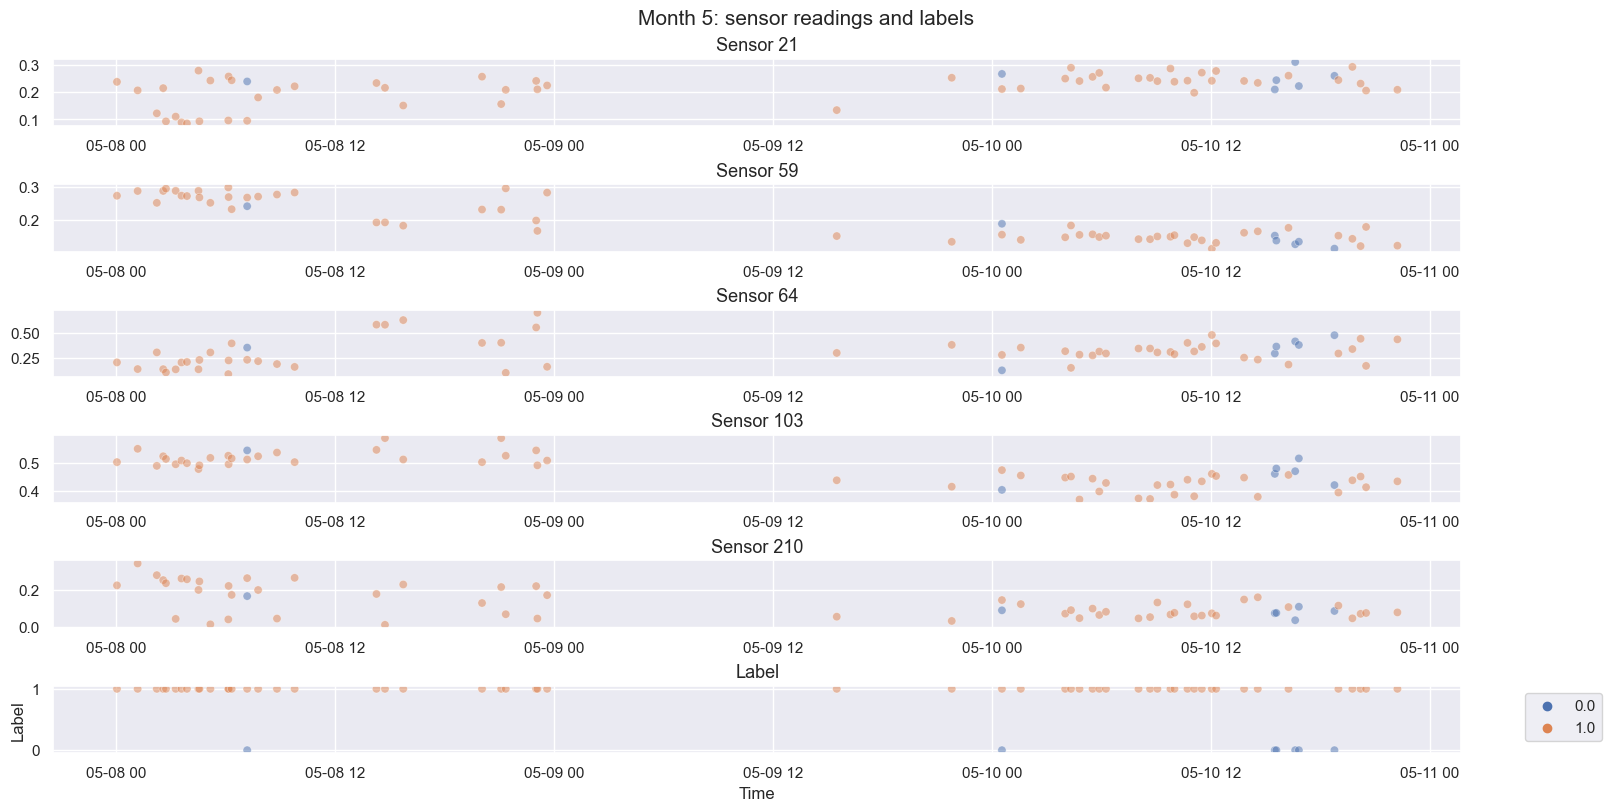

In [528]:
# plot month May
plot_month(4)

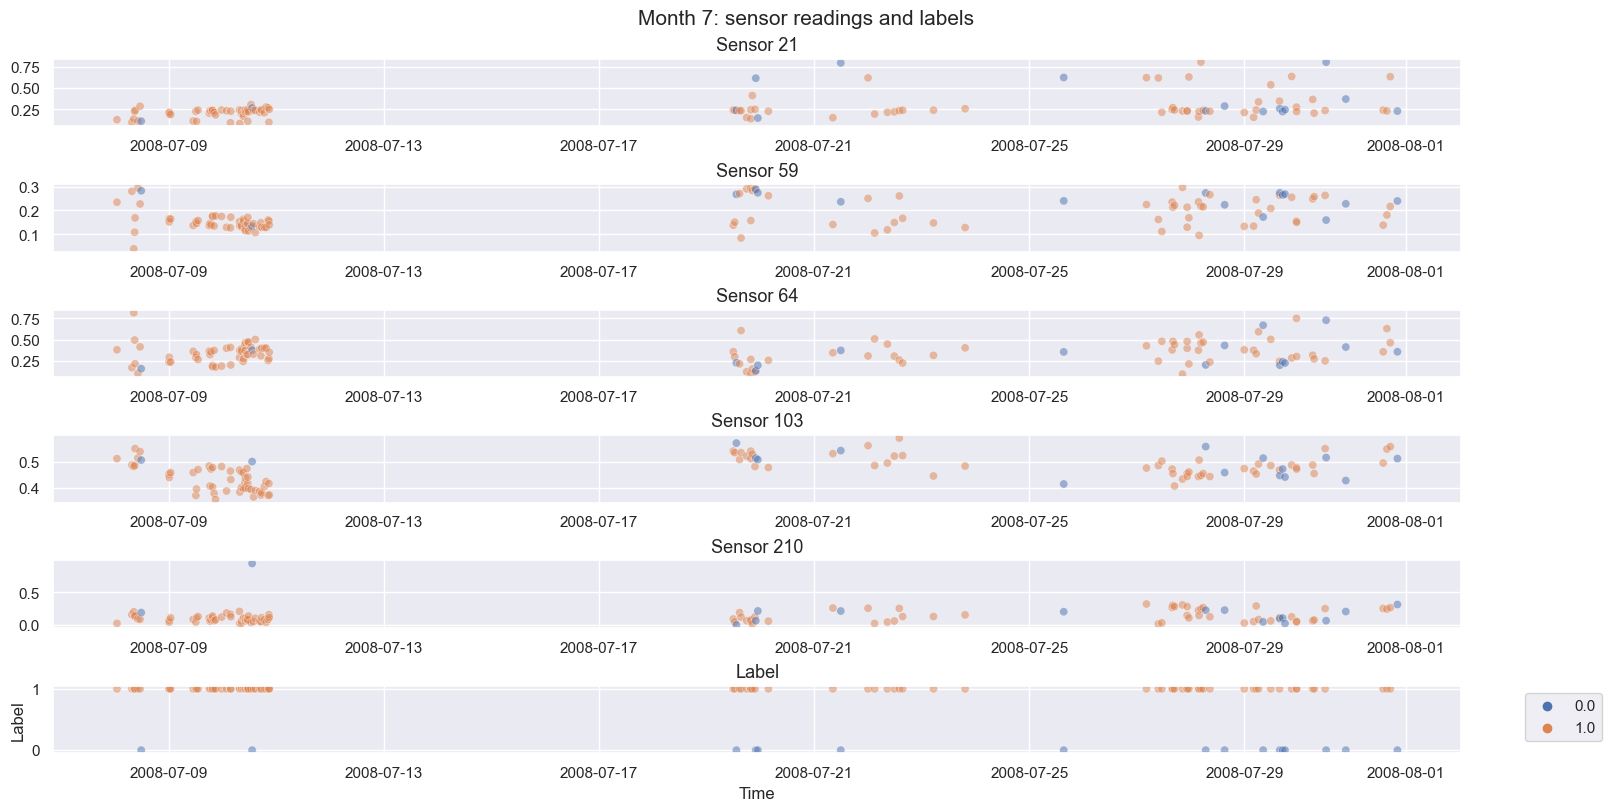

In [529]:
# plot month July
plot_month(6)

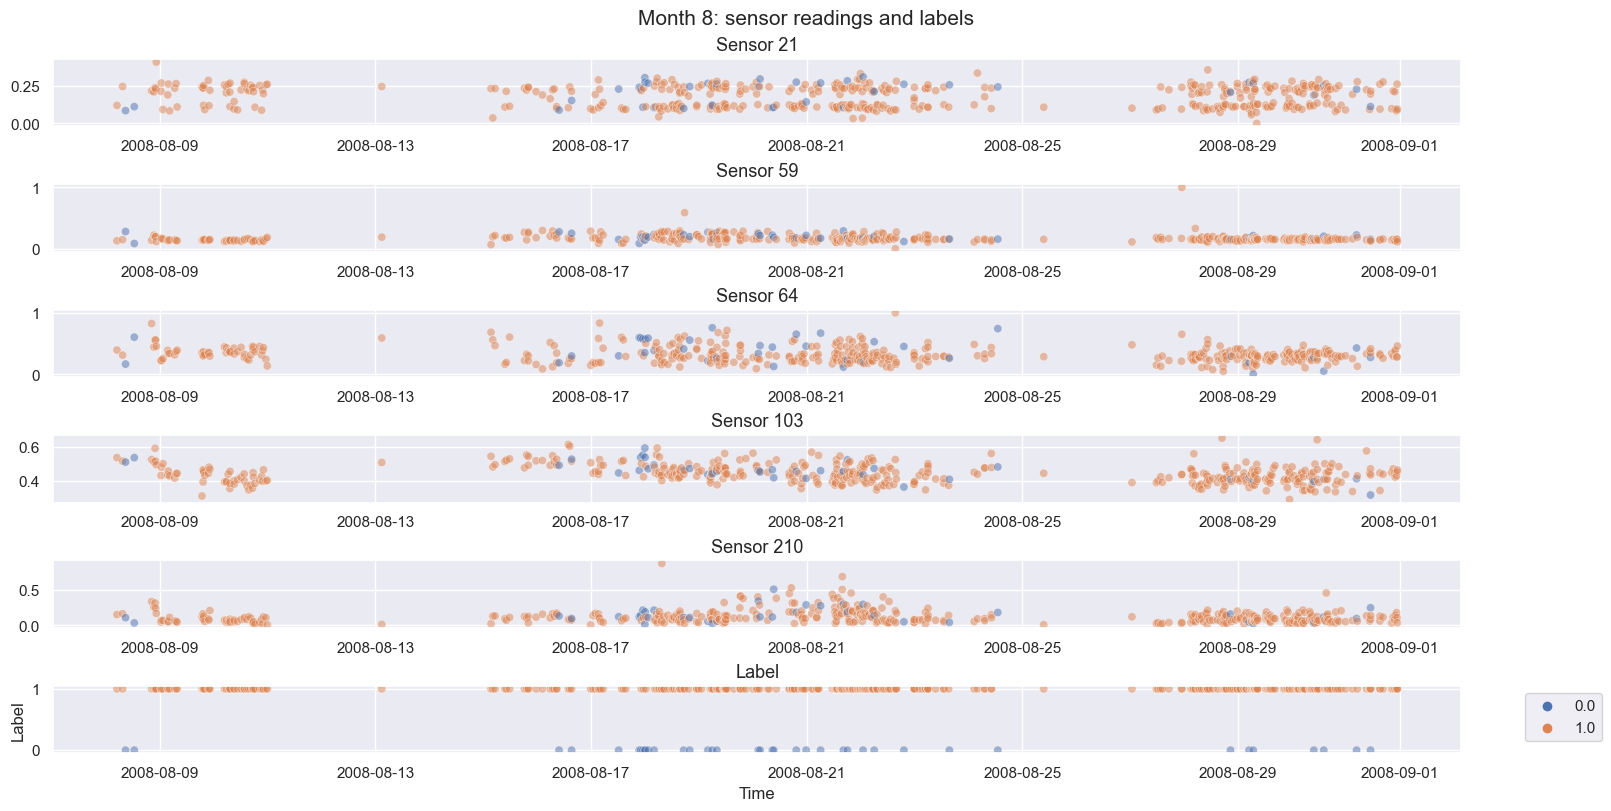

In [534]:
# plot month Sep
plot_month(7)

- from the plots above (May and July) compairing with plot of other month (August), the range of sensor readings are different.
- Sensor 21: August is around 0 to 0.25, May is around 0.1 to 0.3 ; July is in range of 0 to 0.75 and mostly around 0.25 but a bunch of them are above 0.25.
- Sensor 59: August is around 0 to 0.5,May is around 0.1 to 0.3 and most is close to 0.3 or 0.1;,July is in range of 0.1 to 0.3.
- Sensor 64: August is around 0 to 1,May is in reange 0 to 0.5,July is  between 0 and 0.75
- Sensor 103: August is around 0.3 to 0.6,May is in range 0.4 to 0.6 and mostly are centered around 0.5 and 0.4, July is between 0.3 and 0.6 and mostly are centered around 0.4 and 0.5.
- Sensor 210: August is around 0 to 0.5,May is in range of 0 to 0.3,July is in range of 0 to 0.5 but one outlier is above 0.5.

- suggestion to the manufactuary : watch closely to the range of the sensors, maybe program some alarms system to notify if any sensors are out of setted range , so they can act early to prevent more default products

In [531]:
model_compare

,modle,acc,num_miscls
0,RF,0.83,52
1,DNN,0.86,45
2,RNN,0.91,24


### conclusion:
- There are 3 models, one is a random forest classifier and one is a DNN and one is a LSTM from RNN.
- First, the dataset was cleaned and filled all the missing values with random sampled values from the training dataset. A series of feature selection methods were used and LASSO technique reduced the final number of features to 5.
- The dataset has inbalanced classes. SMOTE technique were used to resample classes before modeling.
- The random forest classifier has model accuracy 0.83, DNN model has accuracy 0.86, RNN has an average accuracy of 0.91 through 12 monthes.